# Lab 1 Numpy CNN for inference

In this lab, you are required to fill in the blanks with your code **independently** to complete the inference process of a CNN. Note that there's a bonus at the end of this lab.

**Requirements**

**1. Complete the codes independently.**

**2. Make sure your results are reproducible.**

**3. Do not change the structure of the CNN and the given codes.**

**4. Do not add additional libraries.**

**Submission**

**1. Please submit only this ipynb file via Blackboard.**

**2. Name the ipynb file as "StudentID_StudentName".**

**3. Submit before Oct. 22nd 23:59:59.**

In [2]:
import numpy as np

Define a simple CNN that classifies CIFAR images.
The network provided is similar to LeNet-5, and it has the following architecture:

**Layer** | **Type** | **Input Shape** | **Output Shape** | **Activation**
--- | --- | --- | --- | ---
conv1 | Convolutional | 3x32x32 | 12x28x28 | ReLU 
pool1 | Max pool | 12x28x28 | 12x14x14 | None                
conv2 | Convolutional | 12x14x14 | 32x12x12 | ReLU                
pool2 | Max pool | 32x12x12 | 32x6x6 | None                
fc1 | Fully-connected | 1152 | 256 | ReLU                
fc2 | Fully-connected | 256 | 64 | ReLU                
fc3 | Fully-connected | 64 | 10 | None                

Next, we will build convolution, relu, max-pooling and fully-connected layers using **numpy** respectively (only forward propagation is required for inference).

In [3]:
class ReLU():
    def __init__(self):
        pass

    def forward(self, input: np.ndarray) -> np.ndarray:
        # forward propagation for relu layer
        output = np.maximum(0, input)
        return output

In [4]:
class ConvLayer:  
    def __init__(self, input_channels: int, output_channels: int, kernel_size: int, stride: int, padding: int):   
        self.input_channels: int = input_channels
        self.output_channels: int = output_channels
        self.kernel_size: int = kernel_size  
        self.stride: int = stride
        self.padding: int = padding 
  
    def forward(self, x: np.ndarray, weight: np.ndarray):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        input w: (K, C, R, S) [output channels, input channels, w_height, w_width] 
        output: (N, K, P, Q) [batchsize, output channels, output_height, output_width]
        """  
        assert x.shape[1] == weight.shape[1], "x and weight have different input channels!"
        N, C, H, W = x.shape
        K, C, R, S = weight.shape
        
        
        assert C == self.input_channels, "Invalid Input Channels!"
        assert K == self.output_channels, "Invalid Output Channels!"
         
        # Complete padding operation
        
        # x_padded = np.zeros([N, C, H + 2 * self.padding, W + 2 * self.padding])
        # if (self.padding):
        #     x_padded[:, :, self.padding: -self.padding, self.padding : -self.padding] = x
        x_padded = np.pad(
            x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), 
            mode='constant'
        )
        # Compute output size using self.padding and self.stride
        ## P = floor((H + 2 * padding_x - R) / stride) + 1
        ## Q = floor((W + 2 * padding_y - S) / stride) + 1
        P: np.ndarray = np.floor((H + 2 * self.padding - R) / self.stride) + 1
        Q: np.ndarray = np.floor((W + 2 * self.padding - S) / self.stride) + 1
        P, Q = P.astype(np.int32).item(), Q.astype(np.int32).item()
        
        output = np.zeros([N, K, P, Q])
        # complete convolution operation
        for batch_id in range(N):
            for output_channel in range(K):
                feature = np.zeros([P, Q])
                for input_channel in range(C):
                    # Each Single channel
                    x_processed = x_padded[batch_id, input_channel]
                    w_processed = weight[output_channel, input_channel]
                    for i in range(0, H + 2 * self.padding - R + 1, self.stride):
                        for j in range(0, W + 2 * self.padding - S + 1, self.stride):
                            x_partial = x_processed[i: i + R, j: j + S]
                            #height_partial, width_partial = x_partial.shape
                            #w_partial = w_processed[:height_partial, :width_partial]
                            #feature_propossed = np.sum(x_partial * w_partial)
                            feature_propossed = np.sum(x_partial * w_processed)
                            feature[i // self.stride, j // self.stride] += feature_propossed
                output[batch_id, output_channel] = feature
        return output

In [5]:
class MaxPooling2D:  
    def __init__(self, pool_size: tuple = (2, 2), stride: int = 2):  
        self.pool_size: tuple = pool_size  
        self.stride: int = stride  
    def forward(self, x: np.ndarray):  
        """    
        input x: (N, C, H, W) [batchsize, input channels, x_height, x_width]
        output: (N, C, pooled_height, pooled_width)
        """  
        N, C, H, W = x.shape
        # compute output size using self.pool_size and self.stride
        
        pooled_height: np.ndarray = np.floor((H - self.pool_size[0]) / self.stride) + 1
        pooled_width: np.ndarray = np.floor((W - self.pool_size[1]) / self.stride) + 1
        pooled_height, pooled_width = pooled_height.astype(np.int32).item(), pooled_width.astype(np.int32).item()
  
        output = np.zeros((N, C, pooled_height, pooled_width))
        # complete max-pooling operation
        for batch_id in range(N):
            for input_channel  in range(C):
                feature = np.zeros([pooled_height, pooled_width])
                # Single Image
                x_processed = x[batch_id, input_channel]
                i_cnt, j_cnt = 0, 0
                for i in range(0, H, self.stride):
                    for j in range(0, W, self.stride):
                        feature_processed = np.max(x_processed[i: i+self.pool_size[0], j: j + self.pool_size[1]])
                        feature[i_cnt, j_cnt] = feature_processed
                        j_cnt += 1
                    i_cnt += 1
                    j_cnt = 0
                output[batch_id, input_channel] = feature
        return output

In [6]:
class fclayer():
    def __init__(self, in_features: int, out_features: int):
        self.in_features: int = in_features
        self.out_features: int = out_features
        
    def forward(self, x: np.ndarray, weight: np.ndarray):
        # complete forward propagation of fully-connected layer
        
        assert self.in_features == x.shape[-1]
        assert self.in_features == weight.shape[-1]
        assert self.out_features == weight.shape[0]
        
        output = np.dot(x, weight.T)
        return output  

In [7]:
import torch

# load trained parameters
ckpt: torch.nn.ModuleDict = torch.load('./model/model.pth')
print(ckpt.keys())

odict_keys(['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight'])


In [8]:
def lenet_inf(x: torch.Tensor,ckpt: torch.nn.ModuleDict):
    print(ckpt.keys())
    relu = ReLU().forward
    conv1 = ConvLayer(3, 12, 5, 1, 0)
    conv1_weight: np.ndarray = ckpt["conv1.weight"].cpu().detach().numpy()
    x = conv1.forward(x, conv1_weight)
    x = relu(x)
    maxpool_1 = MaxPooling2D()
    x = maxpool_1.forward(x)
    conv2 = ConvLayer(12, 32, 3, 1, 0)
    conv2_weight = ckpt["conv2.weight"].cpu().detach().numpy()
    x = conv2.forward(x, conv2_weight)
    x = relu(x)
    maxpool_2 = MaxPooling2D()
    x = maxpool_2.forward(x)
    fc1 = fclayer(32*6*6, 256)
    fc1_weight = ckpt["fc1.weight"].cpu().detach().numpy()
    x = x.flatten()
    x = fc1.forward(x, fc1_weight)
    x = relu(x)
    fc2 = fclayer(256, 64)
    fc2_weight = ckpt["fc2.weight"].cpu().detach().numpy()
    x = fc2.forward(x, fc2_weight)
    x = relu(x)
    fc3 = fclayer(64, 10)
    fc3_weight = ckpt["fc3.weight"].cpu().detach().numpy()
    x = fc3.forward(x, fc3_weight)
    output = x
    return output


In [17]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from skimage.transform import resize

# In this lab we will only infer 1 picture from CIFAR-10 datasets to save running time
# you can try different pictures in ./pictures
input_image: np.ndarray = np.array(imageio.imread('./pictures/bird1.png'))

# TODO (5 pts)
# normalize the pixel into [0,1]
min_val, max_val = input_image.min(), input_image.max()
image: np.ndarray = (input_image - min_val) / (max_val - min_val)

# TODO (5 pts)
# alter the size of the pixel matrix from (32,32,3) to (1,3,32,32) to fit convolution layer
## 0, 1, 2 -> new, 2, 0, 1
image = image.transpose(2, 0, 1)
image = np.expand_dims(image, axis = 0)


odict_keys(['conv1.weight', 'conv2.weight', 'fc1.weight', 'fc2.weight', 'fc3.weight'])
Predicted label: 3
Ground truth: 3


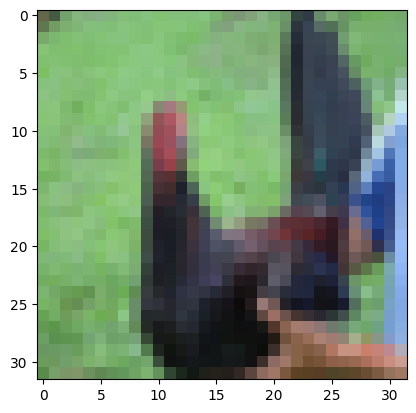

In [18]:
# TODO (5 pts)
# inference using lenet_inf created above
# note that the inference process of 1 picture using numpy may take more than 20 minutes
output = lenet_inf(image, ckpt)
label = np.argmax(output)

import matplotlib.pyplot as plt
# visualize the picture to be classified
plt.imshow(input_image)
print("Predicted label:",label)
print("Ground truth: 3")

Bonus: Calculate the number of computations and parameters. Visualize your results directly in the outputs of your codes. 

Give your answer here.  